# Projet diab-ethique


## Introduction
Nous sommes l’entreprise Diab-Ethique et avons été mandatés par l’entreprise de produits pharmaceutiques Indienne HumanForYou dans le but de les aider à comprendre le turn-over de 15% les touchant chaque année.

En tant que Data-Scientists, nous avons donc été chargés de réaliser une Intelligence Artificielle permettant de comprendre les causes et facteurs de leur changement des effectifs. Nous avons de plus pu réaliser une Intelligence Artificielle permettant de prédire selon le profil d’une personne si elle est susceptible de quitter rapidement HumanForYou ou non si l’entreprise décide de la recruter.

Ce document est donc un notebook présentant notre solution et le code associé d’une Intelligence Artificielle permettant de comprendre les causes et facteurs de leur changement des effectifs.

# Preparation de l'environnement

## Import des librairies

In [1]:
import os
import numpy as np
import pandas as pd
import functools as ft
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as IMBPipeline

## Chargement des données en mémoire

In [2]:
GENERAL_DATA_PATH = os.path.join("Datasets", "general_data")
MANAGER_SURVEY_DATA_PATH = os.path.join("Datasets", "manager_survey_data")
EMPLOYEE_SURVEY_DATA_PATH = os.path.join("Datasets", "employee_survey_data",)

def load_general_data(general_path=GENERAL_DATA_PATH):
    csv_path = os.path.join(general_path, "general_data.csv")
    return pd.read_csv(csv_path)

def load_manager_survey_data(manager_survey_data=MANAGER_SURVEY_DATA_PATH):
    csv_path = os.path.join(manager_survey_data, "manager_survey_data.csv")
    return pd.read_csv(csv_path)

def load_employee_survey_data(employee_survey_data=EMPLOYEE_SURVEY_DATA_PATH):
    csv_path = os.path.join(employee_survey_data, "employee_survey_data.csv")
    return pd.read_csv(csv_path)

general = load_general_data()
manager_survey = load_manager_survey_data()
employee_survey = load_employee_survey_data()

### Groupage des tables entre elles


Il convient ici de regrouper toutes les tables entre elles afin de faciliter leur manipulation.

In [3]:
multiArray = [general, manager_survey, employee_survey]
data = ft.reduce(lambda left, right: pd.merge(left,right,on='EmployeeID'), multiArray)

### Visualisation des données

In [4]:
data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


# Lecture et nettoyage des données

## Cohérence des données

Le nettoyage des données est un processus qui vise à identifier et corriger les données altérées, inexactes ou non pertinentes. Cette étape fondamentale améliore la cohérence, fiabilité et valeur des données. Ici, une vérification rapide permet de définir la cohérence des données. Si certaines données ne sont pas cohérentes, alors un nettoyage des données devra être effectué plus tard.

In [5]:
dtypes = pd.DataFrame(data.dtypes, columns=['Type'])
dtypes['Null'] = data.isnull().sum()
dtypes['N-Unique'] = data.nunique()
dtypes['Unique'] = [data[col].unique() if data[col].dtype == 'object' else [] for col in data.columns]
dtypes.head()
dtypes

,Type,Null,N-Unique,Unique
Age,int64,0,43,[]
Attrition,object,0,2,"[No, Yes]"
BusinessTravel,object,0,3,"[Travel_Rarely, Travel_Frequently, Non-Travel]"
Department,object,0,3,"[Sales, Research & Development, Human Resources]"
DistanceFromHome,int64,0,29,[]
Education,int64,0,5,[]
EducationField,object,0,6,"[Life Sciences, Other, Medical, Marketing, Tec..."
EmployeeCount,int64,0,1,[]
EmployeeID,int64,0,4410,[]
Gender,object,0,2,"[Female, Male]"


Observation : On observe que certaines données ne sont pas traitables. Par exemple, la feature "BusinessTravel" ne peut être traité telle quelle. Une solution serait d'indexer ces valeurs afin de pouvoir les traiter.

## Visualisation graphique des données

La visualisation est un moyen rapide d’obtenir des informations au travers de l’exploration visuelle. 

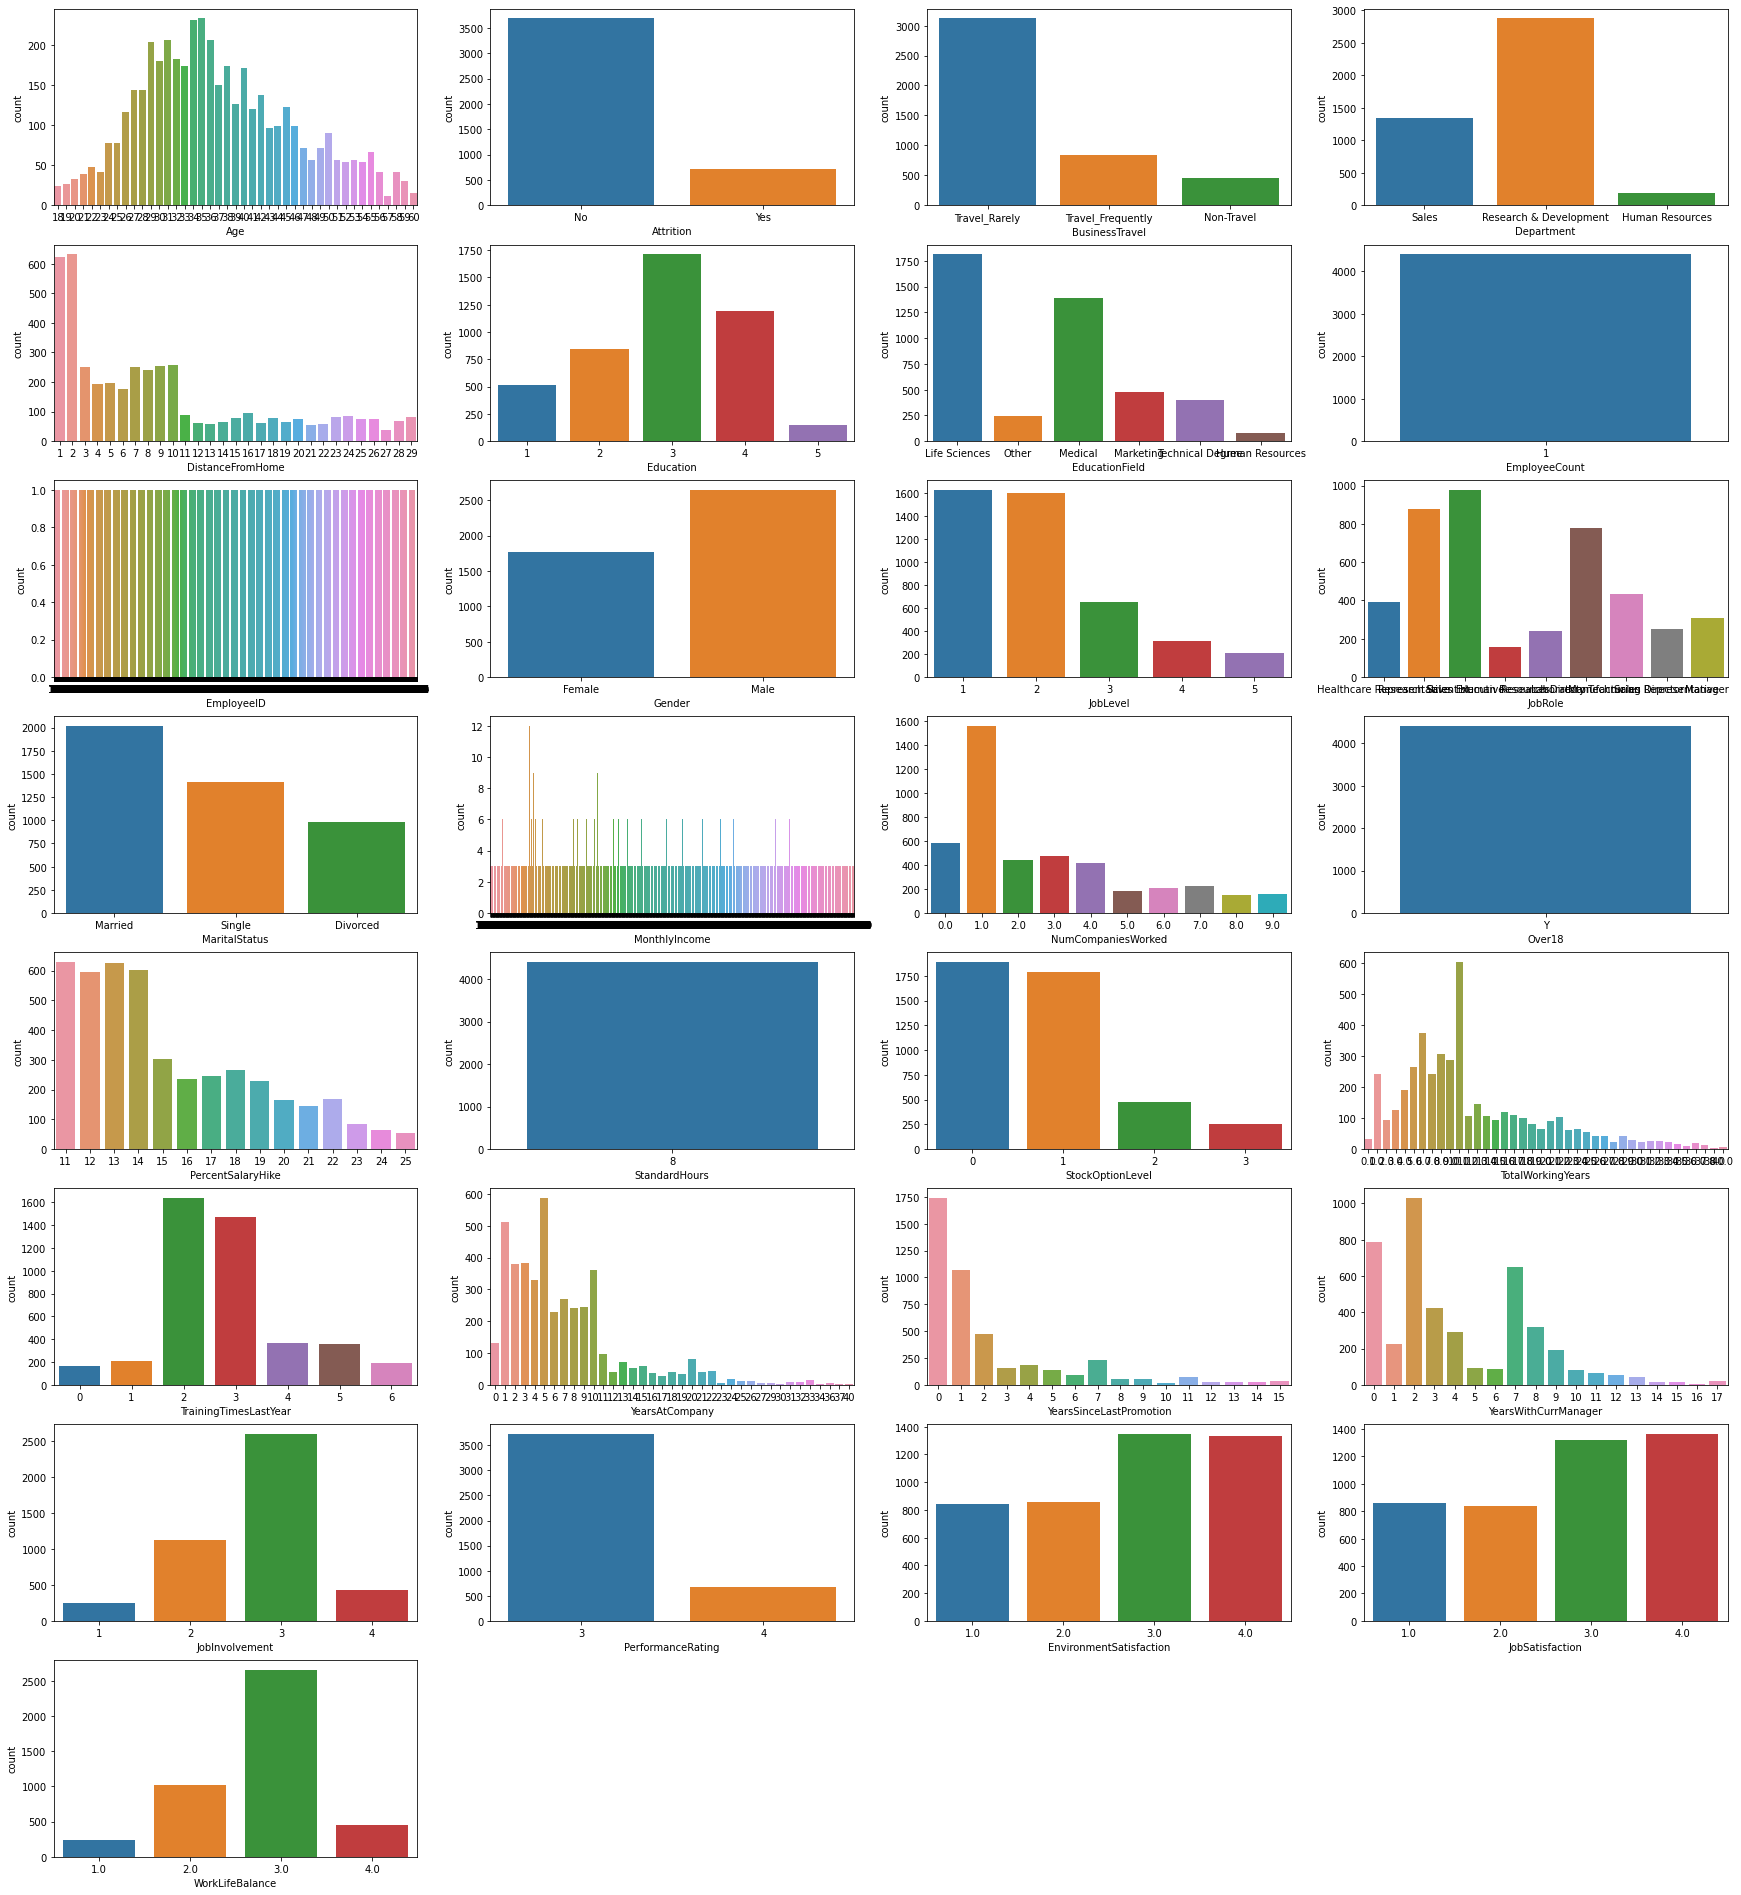

In [6]:
fig = plt.figure(figsize=(30,34))
for idx,i in enumerate(data.columns.tolist()):
    ax=plt.subplot(8,4,idx+1)
    sns.countplot(x=i,data=data,ax=ax)
plt.show()

## Suppression des données jugées non-éthiques

Après un travail préliminaire, certaines données ont été jugées non-ethique. Il convient ici de supprimer ces données de notre jeu de données dans le but de respecter notre éthique.

In [7]:
del data['Gender']
del data['Age']
del data['Over18']
del data['MaritalStatus']
del data['StandardHours']
del data['EmployeeCount']
del data['EmployeeID']

Dans la phase de préparation des données, il est important de toujours visualiser les données. On peut voir ci-dessous notre jeu de données, sans les données supprimé.

In [8]:
data.head()

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,131160,1.0,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,41890,0.0,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,No,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,193280,1.0,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,No,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,83210,3.0,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,No,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,23420,4.0,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


## Numérisation des données

Numérisation des données non traitable.

In [9]:
convert_collumns = {
    'BusinessTravel': 'category',
    'Department': 'category',
    'EducationField': 'category',
    'JobRole': 'category'
}

data = data.astype(convert_collumns)
data_num = data.select_dtypes(include=[np.number])
data['Attrition'] = data['Attrition'].replace(['Yes','No'],[1,0])


# Matrice de corrélation 

Une matrice de corrélation est utilisée pour évaluer la dépendence entre plusieurs variables en même temps. Le résultat est une table contenant les coefficients de corrélation entre chaque variable et les autres. Une visualisation de cette table permet de mieux l'appréhender.

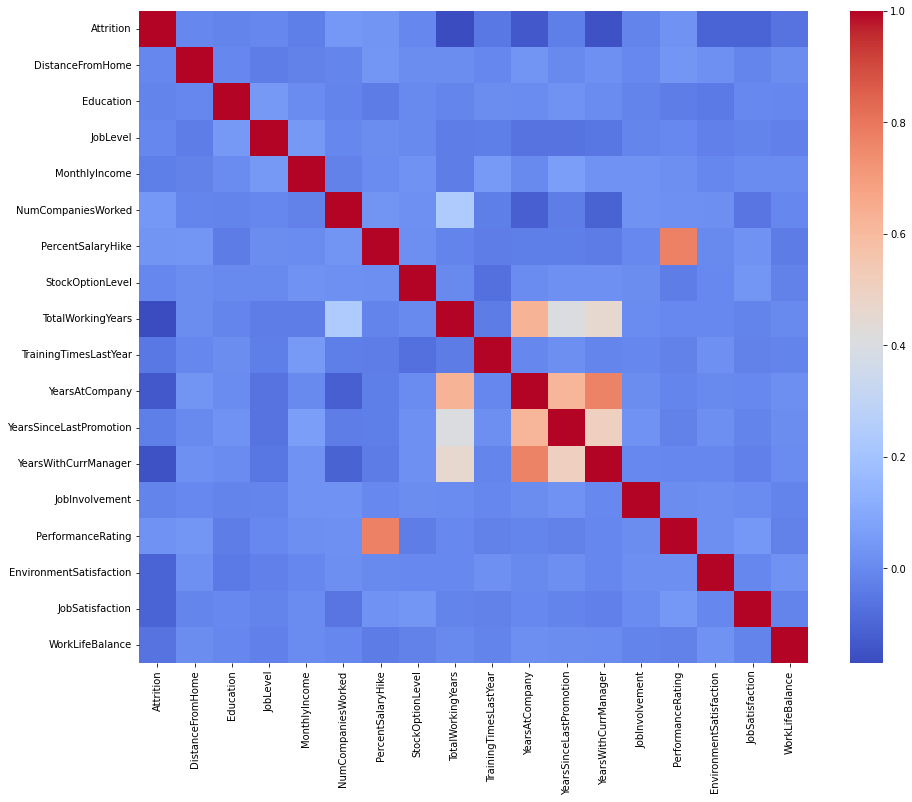

In [10]:
correlation = data.corr()
fig = plt.gcf()
fig.set_size_inches(15,12)
sns.heatmap(correlation,cmap='coolwarm')
plt.show()

Cette matrice nous indique les potentielles données qui influenceraient le départ prématuré (inférieur à 6 mois) d'employé. Par exemple, on peut remarquer que les données "YearsSinceLastPromotion" ainsi que "PerformanceRating" semblent pertinentes dans l'étude des départs prématurés d'employés.

# Distribution des features en fonction du départ de l'employé

Chaque feature est passé au crible. Les résultats ci-dessous sont représentés de la sorte :
* Premier schéma : le premier graphique de chaque section représente la distribution de la feature étudiée ;
* Second schéma : le second graphique est divisé en deux schéma :
    * le schéma de gauche représente la distribution en fonction de la feature "attrition" = 0 (= si l'employé reste) ;
    * le schéma de droite représente la distribution en fonction de la feature "attrition" = 1 (= si l'employé est parti).
* Statistiques : En dessous du second schéma figurent les statistiques (chiffre) correspondant au graphique numéro 2.

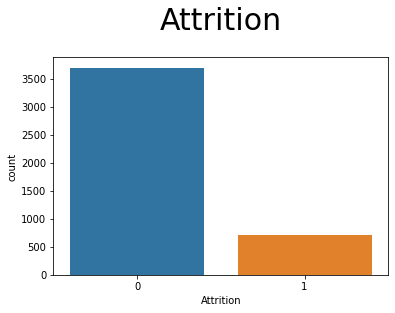

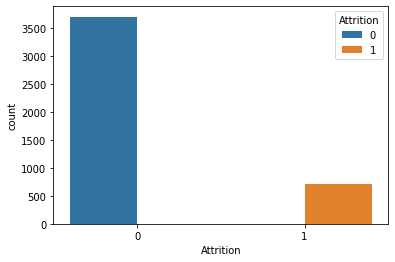

Attrition         0         1
Attrition                    
0          1.000000  0.000000
1          0.000000  1.000000
All        0.838776  0.161224





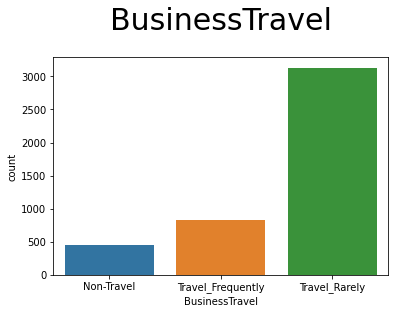

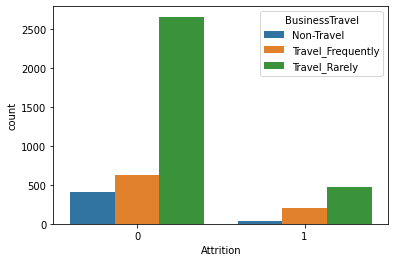

Attrition                 0         1
BusinessTravel                       
Non-Travel         0.920000  0.080000
Travel_Frequently  0.750903  0.249097
Travel_Rarely      0.850431  0.149569
All                0.838776  0.161224





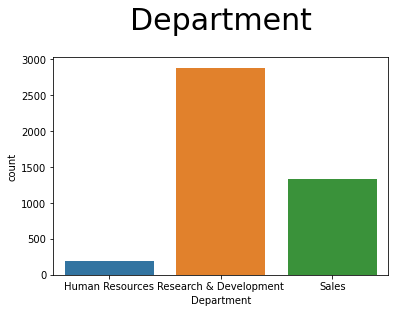

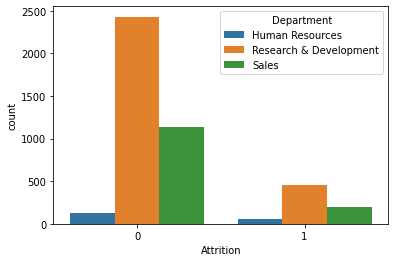

Attrition                      0         1
Department                                
Human Resources         0.698413  0.301587
Research & Development  0.842872  0.157128
Sales                   0.849776  0.150224
All                     0.838776  0.161224





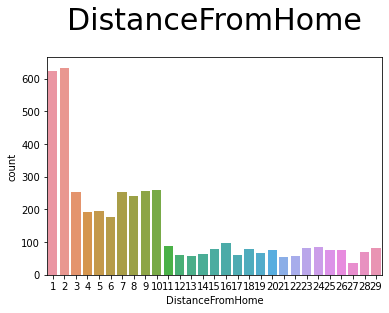

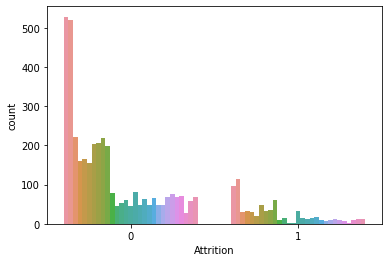

Attrition                0         1
DistanceFromHome                    
1                 0.846154  0.153846
2                 0.819905  0.180095
3                 0.880952  0.119048
4                 0.828125  0.171875
5                 0.846154  0.153846
6                 0.881356  0.118644
7                 0.809524  0.190476
8                 0.862500  0.137500
9                 0.858824  0.141176
10                0.767442  0.232558
11                0.896552  0.103448
12                0.750000  0.250000
13                0.947368  0.052632
14                0.952381  0.047619
15                0.576923  0.423077
16                0.843750  0.156250
17                0.800000  0.200000
18                0.807692  0.192308
19                0.727273  0.272727
20                0.880000  0.120000
21                0.888889  0.111111
22                0.842105  0.157895
23                0.851852  0.148148
24                0.892857  0.107143
25                0.920000  0.080000
2

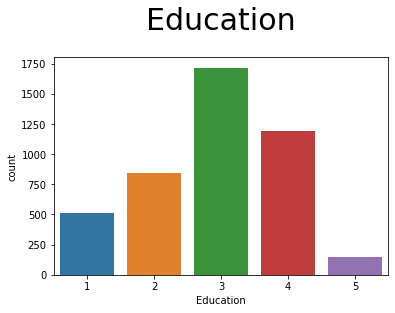

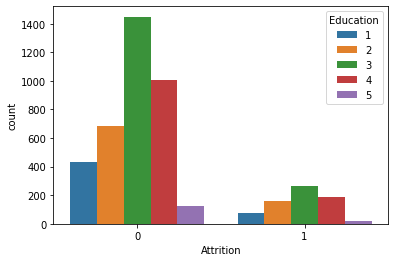

Attrition         0         1
Education                    
1          0.847059  0.152941
2          0.812057  0.187943
3          0.844406  0.155594
4          0.844221  0.155779
5          0.854167  0.145833
All        0.838776  0.161224





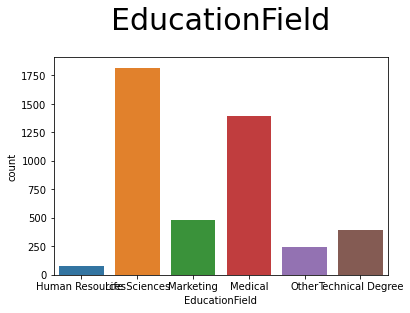

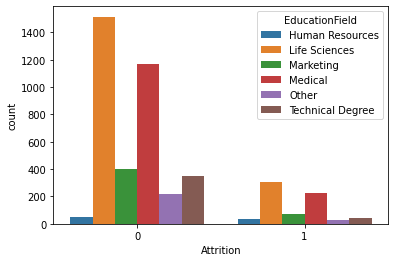

Attrition                0         1
EducationField                      
Human Resources   0.592593  0.407407
Life Sciences     0.833333  0.166667
Marketing         0.842767  0.157233
Medical           0.838362  0.161638
Other             0.878049  0.121951
Technical Degree  0.886364  0.113636
All               0.838776  0.161224





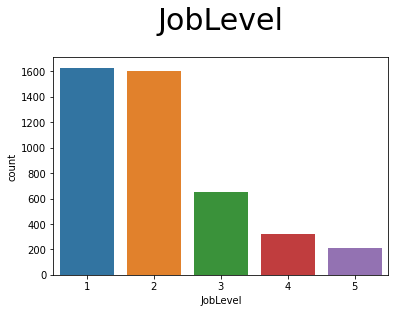

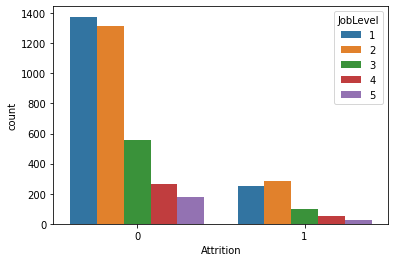

Attrition         0         1
JobLevel                     
1          0.845304  0.154696
2          0.822097  0.177903
3          0.853211  0.146789
4          0.839623  0.160377
5          0.869565  0.130435
All        0.838776  0.161224





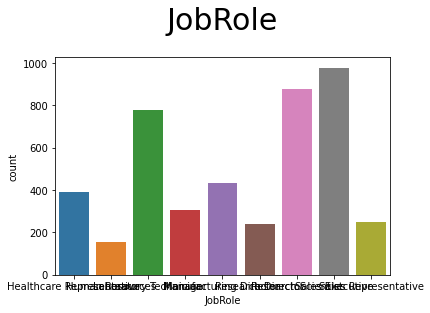

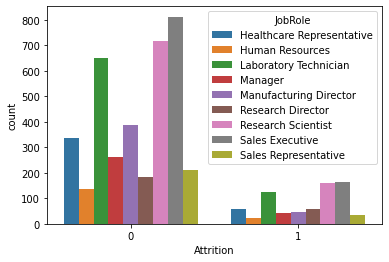

Attrition                         0         1
JobRole                                      
Healthcare Representative  0.854962  0.145038
Human Resources            0.865385  0.134615
Laboratory Technician      0.837838  0.162162
Manager                    0.862745  0.137255
Manufacturing Director     0.889655  0.110345
Research Director          0.762500  0.237500
Research Scientist         0.818493  0.181507
Sales Executive            0.831288  0.168712
Sales Representative       0.855422  0.144578
All                        0.838776  0.161224





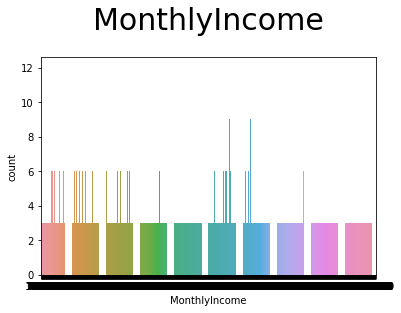

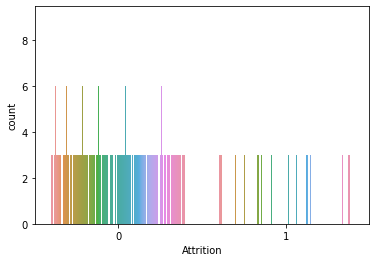

Attrition             0         1
MonthlyIncome                    
10090          0.000000  1.000000
10510          1.000000  0.000000
10520          1.000000  0.000000
10810          1.000000  0.000000
10910          1.000000  0.000000
...                 ...       ...
199260         1.000000  0.000000
199430         1.000000  0.000000
199730         1.000000  0.000000
199990         1.000000  0.000000
All            0.838776  0.161224

[1350 rows x 2 columns]





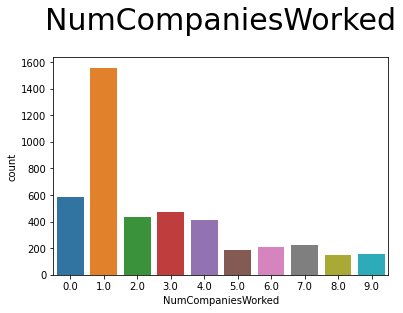

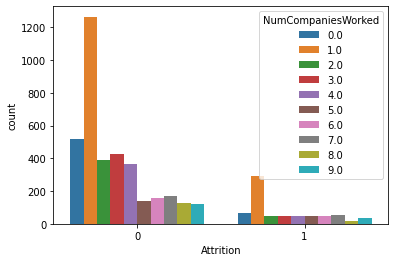

Attrition                  0         1
NumCompaniesWorked                    
0.0                 0.882253  0.117747
1.0                 0.811938  0.188062
2.0                 0.890411  0.109589
3.0                 0.898734  0.101266
4.0                 0.879518  0.120482
5.0                 0.754011  0.245989
6.0                 0.769231  0.230769
7.0                 0.770270  0.229730
8.0                 0.877551  0.122449
9.0                 0.769231  0.230769
All                 0.838989  0.161011





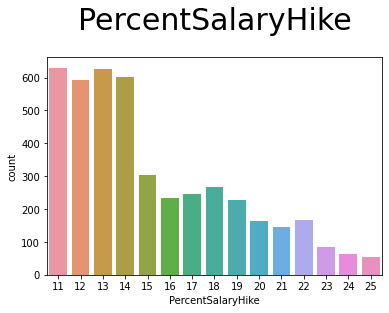

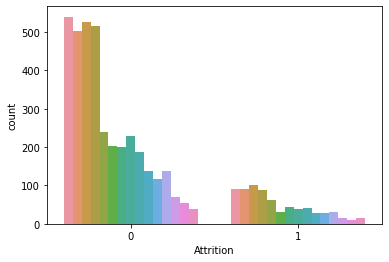

Attrition                 0         1
PercentSalaryHike                    
11                 0.857143  0.142857
12                 0.848485  0.151515
13                 0.837321  0.162679
14                 0.855721  0.144279
15                 0.792079  0.207921
16                 0.871795  0.128205
17                 0.817073  0.182927
18                 0.853933  0.146067
19                 0.815789  0.184211
20                 0.836364  0.163636
21                 0.812500  0.187500
22                 0.821429  0.178571
23                 0.821429  0.178571
24                 0.857143  0.142857
25                 0.722222  0.277778
All                0.838776  0.161224





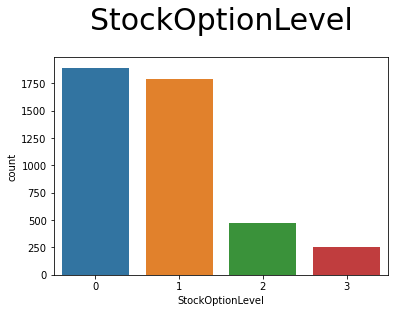

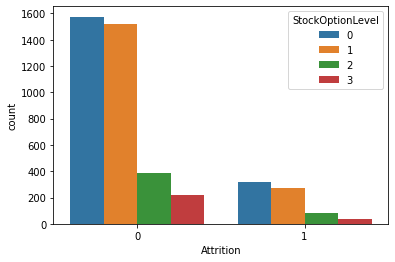

Attrition                0         1
StockOptionLevel                    
0                 0.832013  0.167987
1                 0.848993  0.151007
2                 0.822785  0.177215
3                 0.847059  0.152941
All               0.838776  0.161224





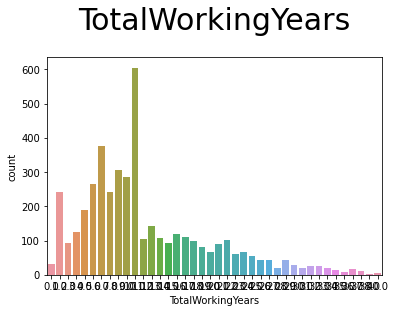

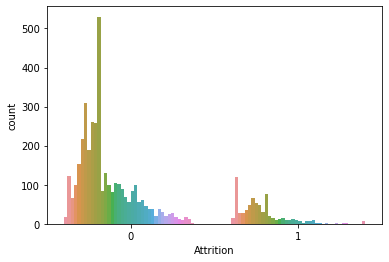

Attrition                 0         1
TotalWorkingYears                    
0.0                0.545455  0.454545
1.0                0.508264  0.491736
2.0                0.709677  0.290323
3.0                0.785714  0.214286
4.0                0.809524  0.190476
5.0                0.818182  0.181818
6.0                0.824000  0.176000
7.0                0.777778  0.222222
8.0                0.846906  0.153094
9.0                0.895470  0.104530
10.0               0.876033  0.123967
11.0               0.801887  0.198113
12.0               0.895833  0.104167
13.0               0.916667  0.083333
14.0               0.870968  0.129032
15.0               0.875000  0.125000
16.0               0.918919  0.081081
17.0               0.909091  0.090909
18.0               0.851852  0.148148
19.0               0.863636  0.136364
20.0               0.932584  0.067416
21.0               0.970588  0.029412
22.0               0.903226  0.096774
23.0               0.909091  0.090909
24.0        

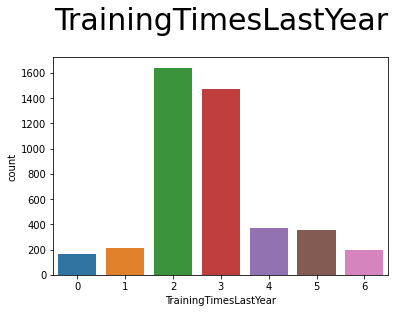

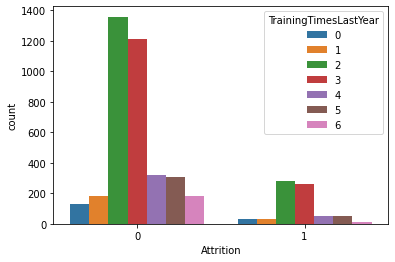

Attrition                     0         1
TrainingTimesLastYear                    
0                      0.814815  0.185185
1                      0.859155  0.140845
2                      0.828154  0.171846
3                      0.824847  0.175153
4                      0.869919  0.130081
5                      0.857143  0.142857
6                      0.938462  0.061538
All                    0.838776  0.161224





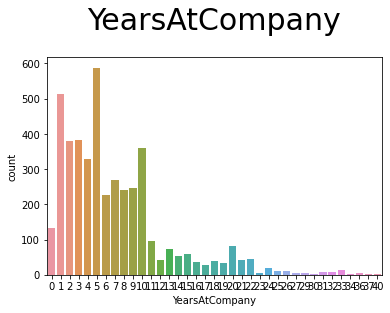

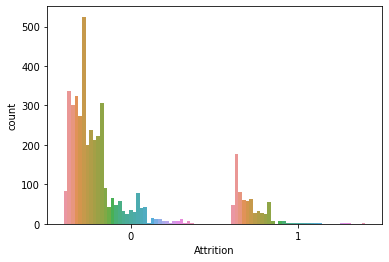

Attrition              0         1
YearsAtCompany                    
0               0.636364  0.363636
1               0.654971  0.345029
2               0.787402  0.212598
3               0.843750  0.156250
4               0.827273  0.172727
5               0.892857  0.107143
6               0.881579  0.118421
7               0.877778  0.122222
8               0.887500  0.112500
9               0.902439  0.097561
10              0.850000  0.150000
11              0.937500  0.062500
12              1.000000  0.000000
13              0.916667  0.083333
14              0.888889  0.111111
15              0.950000  0.050000
16              0.916667  0.083333
17              0.888889  0.111111
18              0.923077  0.076923
19              0.909091  0.090909
20              0.962963  0.037037
21              0.928571  0.071429
22              0.933333  0.066667
23              0.500000  0.500000
24              0.833333  0.166667
25              1.000000  0.000000
26              1.00

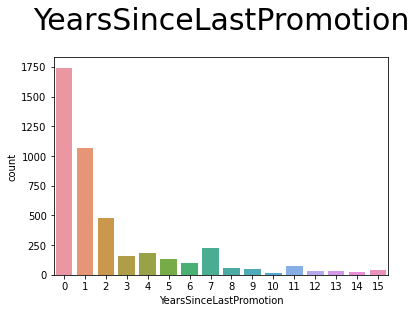

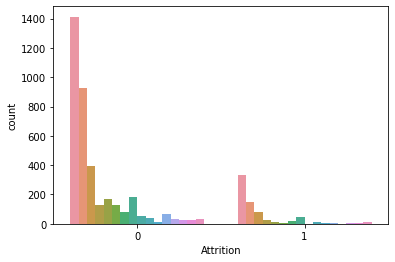

Attrition                       0         1
YearsSinceLastPromotion                    
0                        0.810671  0.189329
1                        0.862745  0.137255
2                        0.830189  0.169811
3                        0.826923  0.173077
4                        0.918033  0.081967
5                        0.955556  0.044444
6                        0.812500  0.187500
7                        0.789474  0.210526
8                        1.000000  0.000000
9                        0.764706  0.235294
10                       0.833333  0.166667
11                       0.916667  0.083333
12                       1.000000  0.000000
13                       0.800000  0.200000
14                       0.888889  0.111111
15                       0.769231  0.230769
All                      0.838776  0.161224





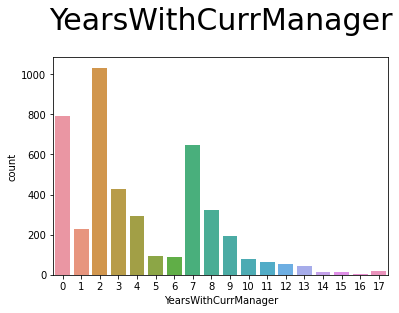

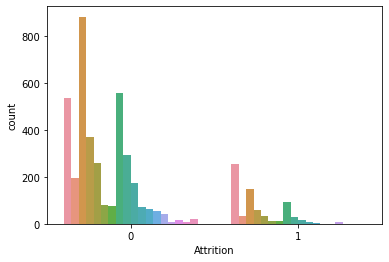

Attrition                    0         1
YearsWithCurrManager                    
0                     0.676806  0.323194
1                     0.855263  0.144737
2                     0.854651  0.145349
3                     0.866197  0.133803
4                     0.887755  0.112245
5                     0.870968  0.129032
6                     0.862069  0.137931
7                     0.856481  0.143519
8                     0.906542  0.093458
9                     0.906250  0.093750
10                    0.888889  0.111111
11                    0.954545  0.045455
12                    1.000000  0.000000
13                    1.000000  0.000000
14                    0.600000  0.400000
15                    1.000000  0.000000
16                    1.000000  0.000000
17                    1.000000  0.000000
All                   0.838776  0.161224





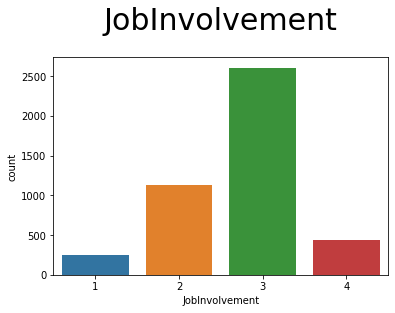

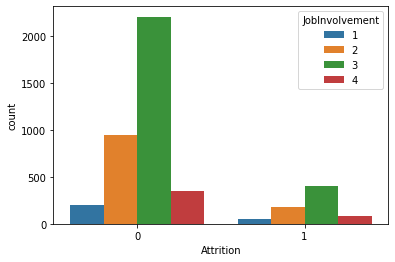

Attrition              0         1
JobInvolvement                    
1               0.783133  0.216867
2               0.840000  0.160000
3               0.846774  0.153226
4               0.819444  0.180556
All             0.838776  0.161224





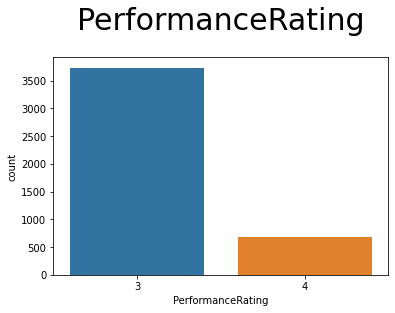

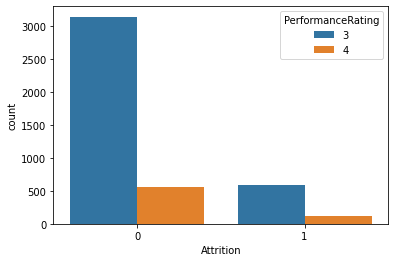

Attrition                 0         1
PerformanceRating                    
3                  0.842444  0.157556
4                  0.818584  0.181416
All                0.838776  0.161224





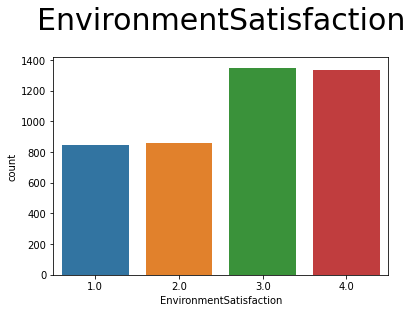

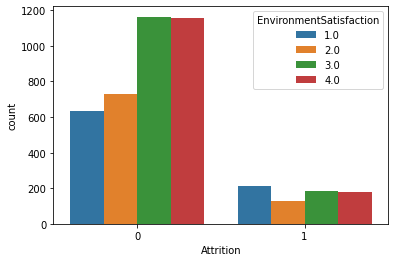

Attrition                       0         1
EnvironmentSatisfaction                    
1.0                      0.747929  0.252071
2.0                      0.850467  0.149533
3.0                      0.862222  0.137778
4.0                      0.865817  0.134183
All                      0.838997  0.161003





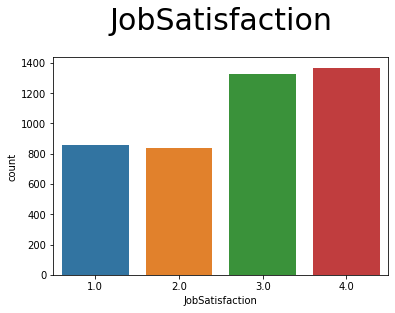

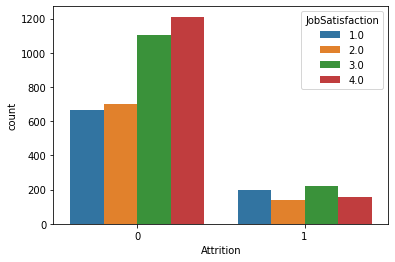

Attrition               0         1
JobSatisfaction                    
1.0              0.770930  0.229070
2.0              0.835714  0.164286
3.0              0.834467  0.165533
4.0              0.885881  0.114119
All              0.838269  0.161731





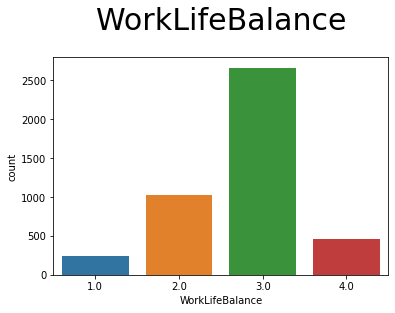

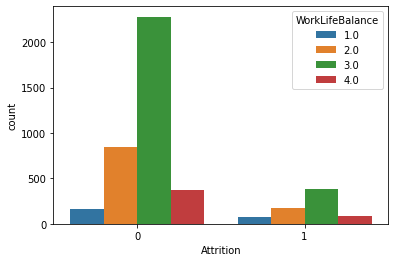

Attrition               0         1
WorkLifeBalance                    
1.0              0.686192  0.313808
2.0              0.832188  0.167812
3.0              0.857143  0.142857
4.0              0.821586  0.178414
All              0.838289  0.161711





In [11]:
for i, column in enumerate(data.columns):
    sns.countplot(x=column, data=data).set_title(column, y=1.1, fontsize=30)
    plt.show()
    g = sns.countplot(x= 'Attrition', data=data, hue=column)
    if data[column].nunique()>10:
        plt.legend([],[], frameon=False)
    plt.show()
    print(pd.crosstab(columns=[data.Attrition], index=[data[column]], margins=True, normalize='index'))
    print('\n\n')

## Encodage des valeurs quantitatives

Les données quantitatives ne sont pas traitables telles quelles. En effet, le traitement d'une donnée quantitative requiert une numérisation. 

In [12]:
categories_attributes = ["Department", "EducationField", "JobRole", 'BusinessTravel']
data_prepared = pd.get_dummies(data, columns=categories_attributes)
data_prepared.head(n=20)

,Attrition,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely
0,0,6,2,1,131160,1.0,11,0,1.0,6,...,0,0,0,0,0,0,0,0,0,1
1,1,10,1,1,41890,0.0,23,1,6.0,3,...,0,0,0,0,1,0,0,0,1,0
2,0,17,4,4,193280,1.0,15,3,5.0,2,...,0,0,0,0,0,1,0,0,1,0
3,0,2,5,3,83210,3.0,11,3,13.0,5,...,0,0,0,0,0,0,0,1,0,0
4,0,10,1,1,23420,4.0,12,2,9.0,2,...,0,0,0,0,0,1,0,0,0,1
5,0,8,3,4,40710,3.0,13,0,28.0,5,...,0,0,0,1,0,0,0,0,0,1
6,1,11,2,2,58130,2.0,20,1,5.0,2,...,0,0,0,0,0,1,0,0,0,1
7,0,18,3,2,31430,2.0,22,3,10.0,2,...,0,0,0,0,0,1,0,0,0,1
8,0,1,3,3,20440,0.0,21,0,10.0,2,...,1,0,0,0,0,0,0,0,0,1
9,0,7,4,4,134640,1.0,13,1,6.0,2,...,1,0,0,0,0,0,0,1,0,0


## Remise à l'échelle

/home/xlabarbe/.local/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/xlabarbe/.local/lib/python3.10/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


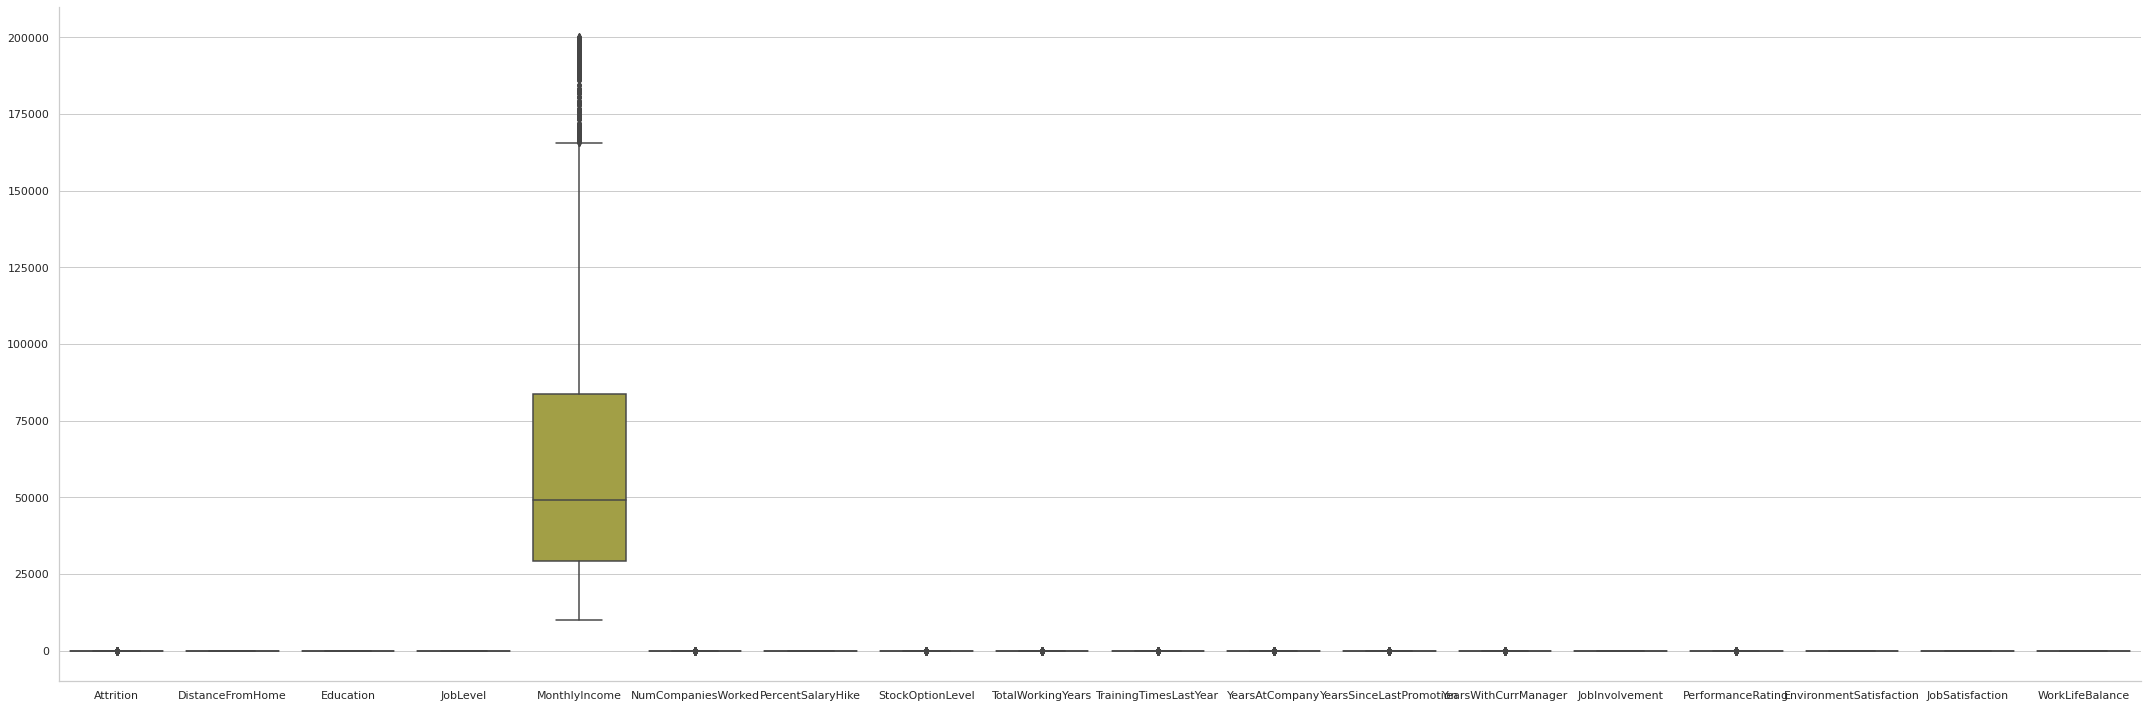

In [217]:
sns.factorplot(data=data, kind='box',size=10,aspect=3)

/home/xlabarbe/.local/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/xlabarbe/.local/lib/python3.10/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


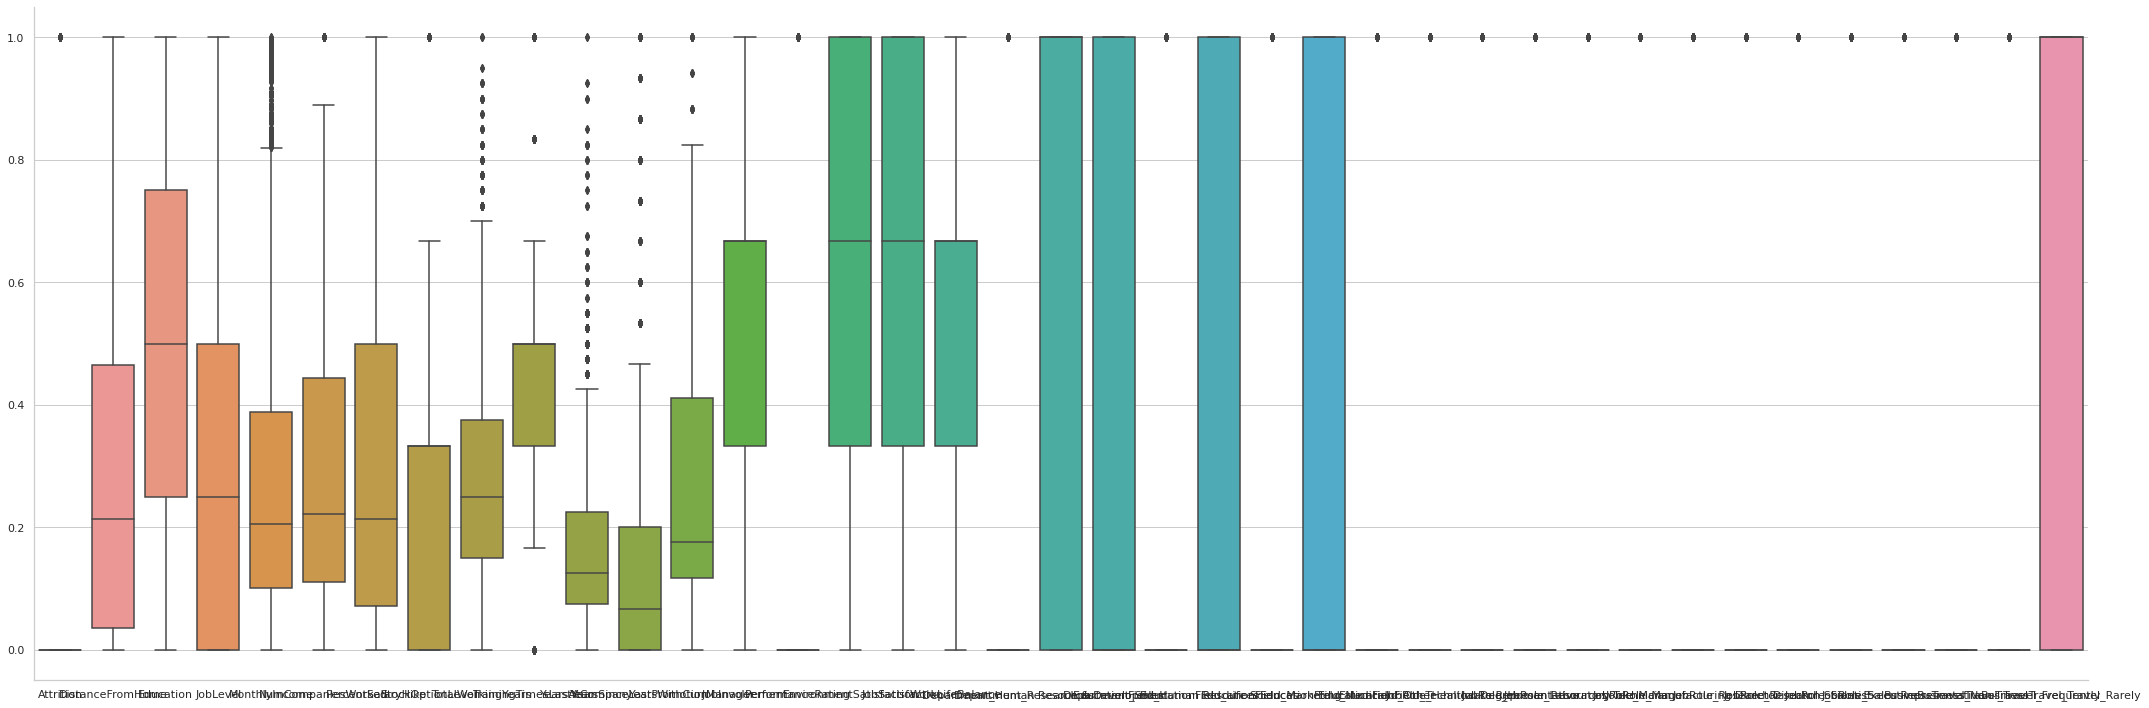

In [218]:
monthly_income_scaled = MinMaxScaler()
data_prepared = pd.DataFrame(monthly_income_scaled.fit_transform(data_prepared), columns = data_prepared.columns)
sns.factorplot(data=data_prepared, kind='box',size=10,aspect=3)

In [219]:
knnImputer = KNNImputer()
data_prepared = pd.DataFrame(knnImputer.fit_transform(data_prepared), columns=data_prepared.columns)
data_prepared.isna().sum()

Attrition                            0
DistanceFromHome                     0
Education                            0
JobLevel                             0
MonthlyIncome                        0
NumCompaniesWorked                   0
PercentSalaryHike                    0
StockOptionLevel                     0
TotalWorkingYears                    0
TrainingTimesLastYear                0
YearsAtCompany                       0
YearsSinceLastPromotion              0
YearsWithCurrManager                 0
JobInvolvement                       0
PerformanceRating                    0
EnvironmentSatisfaction              0
JobSatisfaction                      0
WorkLifeBalance                      0
Department_Human Resources           0
Department_Research & Development    0
Department_Sales                     0
EducationField_Human Resources       0
EducationField_Life Sciences         0
EducationField_Marketing             0
EducationField_Medical               0
EducationField_Other     

## Pipeline
### Transformation pipeline
Cette partie consiste à automatiser toutes les transformations, que nous avons vu précedemment, effectuées sur notre dataset.

In [220]:
numeric_transformer = SKPipeline(steps=[('imputer', KNNImputer()), ('scaler', MinMaxScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordianl_transformer = OrdinalEncoder(categories=[['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']])

num_data = list(data_num)
cat_data = ["Department", "EducationField", "JobRole"]
ordi_data = ["BusinessTravel"]

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_data),
    ('cat', categorical_transformer, cat_data),
    ('ordi', ordianl_transformer, ordi_data)
])

## Test de la pipeline

In [221]:
data.head()

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,0,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,131160,1.0,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,1,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,41890,0.0,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,0,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,193280,1.0,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,0,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,83210,3.0,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,0,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,23420,4.0,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


In [222]:
data_prepared_pl = pd.DataFrame(preprocessor.fit_transform(data))
all_columns = np.concatenate((data.columns.drop(labels=cat_data + ordi_data + ["Attrition"]), preprocessor.named_transformers_['cat'].get_feature_names_out(), ordi_data), axis=0)
data_prepared_pl.columns = all_columns
data_prepared_pl.head(n=20)

,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,...,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,BusinessTravel
0,0.178571,0.25,0.00,0.637546,0.111111,0.000000,0.000000,0.025,1.000000,0.025,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.321429,0.00,0.00,0.167457,0.000000,0.857143,0.333333,0.150,0.500000,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
2,0.571429,0.75,0.75,0.964666,0.111111,0.285714,1.000000,0.125,0.333333,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
3,0.035714,1.00,0.50,0.385045,0.333333,0.000000,1.000000,0.325,0.833333,0.200,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.321429,0.00,0.00,0.070195,0.444444,0.071429,0.666667,0.225,0.333333,0.150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,0.250000,0.50,0.75,0.161243,0.333333,0.142857,0.000000,0.700,0.833333,0.175,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,0.357143,0.25,0.25,0.252975,0.222222,0.642857,0.333333,0.125,0.333333,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,0.607143,0.50,0.25,0.112375,0.222222,0.785714,1.000000,0.250,0.333333,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.000000,0.50,0.50,0.054502,0.000000,0.714286,0.000000,0.250,0.333333,0.225,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.214286,0.75,0.75,0.655872,0.111111,0.142857,0.333333,0.150,0.333333,0.150,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modélisation des algorithmes
La partie modélisation est le moment où nous commençons à utiliser les outils de l'IA. L'objectif de cette partie est d'anticiper au mieux le profil des personnes qui partent de l'entreprise.

In [223]:
X = data.drop('Attrition', axis=1)
Y = data['Attrition']

X_m = data_prepared_pl
Y_m = data['Attrition']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

X_train_m, X_test_m, Y_train_m, Y_test_m = train_test_split(X_m, Y_m, test_size=0.2)

### Manuelle
Dans un premier temps nous allons faire la modélisation à la main pour avoir une référence avant de mettre en place une automatisation.

In [224]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('(ROC) Curve')
    plt.show()

In [225]:
def getMetrics(model, X, Y):
  Y_pred = model.predict(X)

  accuracy_score_res = accuracy_score(Y,Y_pred)
  precision_score_res = precision_score(Y,Y_pred)
  recall_score_res = recall_score(Y,Y_pred)
  f1_score_res = f1_score(Y,Y_pred)
  auc_score_res = roc_auc_score(Y, Y_pred)     
  fpr, tpr, thresholds = roc_curve(Y, Y_pred)

  print('Accuracy Score : ' + str(accuracy_score(Y,Y_pred)))
  print('Precision Score : ' + str(precision_score(Y,Y_pred)))
  print('Recall Score : ' + str(recall_score(Y,Y_pred)))
  print('F1 Score : ' + str(f1_score(Y,Y_pred)))
  print('AUC: %.2f' % auc_score_res)
  print('Confusion Matrix : \n' + str(confusion_matrix(Y, Y_pred)))
  plot_roc_curve(fpr, tpr)


  return [accuracy_score_res, precision_score_res, recall_score_res, f1_score_res]


On réalise les calculs métriques manuellement afin d'avoir un élément de comparaison avec notre automatisation qui vient juste après.

0.8385269121813032
0.8555240793201133
0.8413597733711048
0.8413597733711048
0.8413597733711048
0.8526912181303116
0.8498583569405099
0.8413597733711048
0.8210227272727273
0.8465909090909091
Cross Validation :  0.8429653296420293
Accuracy Score : 0.8492063492063492
Precision Score : 0.6842105263157895
Recall Score : 0.09285714285714286
F1 Score : 0.16352201257861634
AUC: 0.54
Confusion Matrix : 
[[736   6]
 [127  13]]


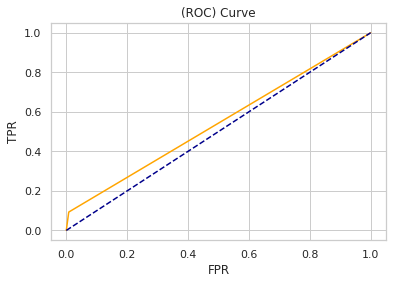

[0.8492063492063492,
 0.6842105263157895,
 0.09285714285714286,
 0.16352201257861634]

In [226]:
m_method = LogisticRegression(solver='liblinear', C=100, random_state=42)
skfolds = StratifiedKFold(n_splits=10)
result = []

# Manual cross validation
for train_index, test_index in skfolds.split(X_train_m, Y_train_m):
    clone_m_method = clone(m_method)
    X_train_folds, X_test_fold = X_train_m.iloc[train_index], X_train_m.iloc[test_index]
    Y_train_folds, Y_test_fold = Y_train_m.iloc[train_index], Y_train_m.iloc[test_index]

    clone_m_method.fit(X_train_folds, Y_train_folds)
    Y_pred = clone_m_method.predict(X_test_fold)
    n_correct = sum(Y_pred == Y_test_fold)
    result.append(n_correct / len(Y_pred))
    print(n_correct / len(Y_pred))

print("Cross Validation : ", np.mean(result))
m_method.fit(X_train_m, Y_train_m)
getMetrics(m_method, X_test_m, Y_test_m)

### Automatisation
Nous allons rendre la modélisation automatique pour être capable de rapidement mettre en place des modèles.

In [227]:
def showModel(grid, kernel):
    if ((kernel == None) or (kernel == 'rbf' ) or (kernel == 'poly')):
        print("{} not supported with Coef_ Funtion".format(kernel))
    else:
        coefs=sorted(zip(grid.best_estimator_.named_steps['classifier'].coef_[0],X_train.columns.tolist()))
        feat=X_train.columns.tolist()
                
        top10Negative=coefs[:10]
        top10Postive=coefs[::-1][:10]

        res_neg=pd.DataFrame(top10Negative,columns=['Values','Top10NegativeFeatures'])
        res_pos=pd.DataFrame(top10Postive,columns=['Values','Top10PostiveFeatures'])
        res=pd.concat([res_neg,res_pos],axis=1)

        feat=[i[1] for i in coefs]
        coefs1=[i[0] for i in coefs]
        plt.figure(figsize=(10,14))
        plt.barh(range(len(feat)), coefs1, align='center')
        plt.yticks(range(len(feat)), feat)
        plt.show()

In [228]:
def testModel(method, oversampled = False, params = {}, cv = 5, kernel=None):
  if (oversampled):
    fullpipeline = IMBPipeline(steps=[
        ('preprocessor', preprocessor),
        ('sampling', SMOTE()),
        ('classifier', method)
    ])
  else:
    fullpipeline = SKPipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', method)
    ])

  grid = GridSearchCV(fullpipeline, param_grid=params,cv=cv)
  grid.fit(X_train, Y_train)
  print(grid.best_params_)
  showModel(grid, kernel)
  return getMetrics(grid.best_estimator_, X_test, Y_test)

### Avant l'*oversampling*

In [229]:
models_bo = []

#### Régression Logistique

{'classifier__C': 10, 'classifier__solver': 'liblinear'}


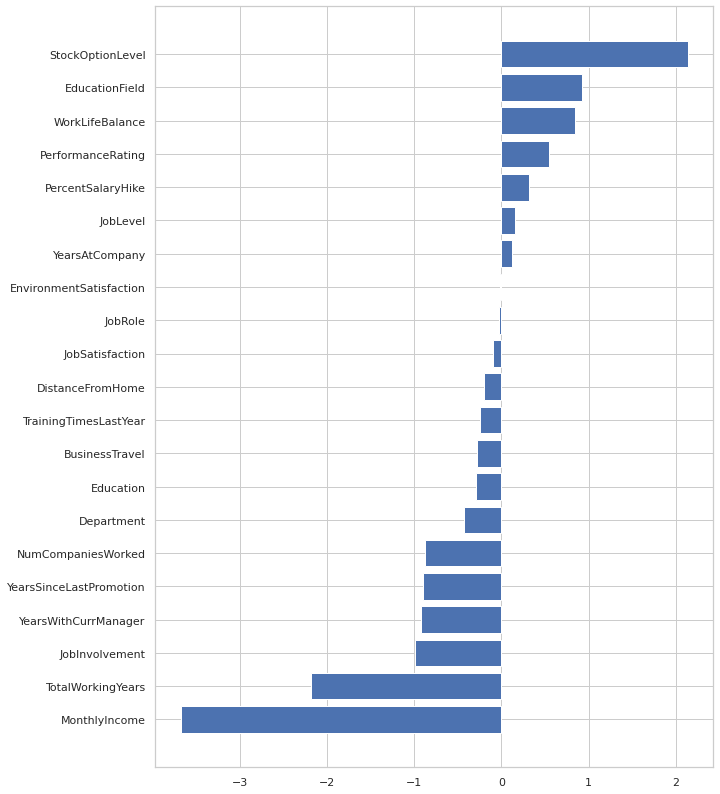

Accuracy Score : 0.8242630385487528
Precision Score : 0.6333333333333333
Recall Score : 0.1165644171779141
F1 Score : 0.19689119170984457
AUC: 0.55
Confusion Matrix : 
[[708  11]
 [144  19]]


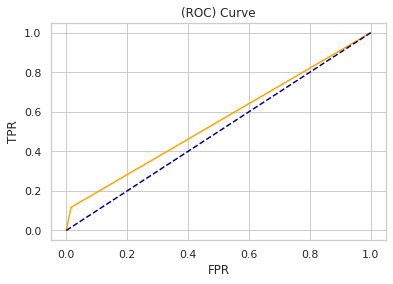

In [230]:
lr = LogisticRegression()

params = {
    'classifier__C': [10, 100],
    'classifier__solver' : ['liblinear']
}

result = testModel(method=lr, params=params, kernel="linear")
models_bo.append(result)

#### POLY SVM

{'classifier__C': 100, 'classifier__kernel': 'poly'}
poly not supported with Coef_ Funtion
Accuracy Score : 0.9739229024943311
Precision Score : 0.9320987654320988
Recall Score : 0.9263803680981595
F1 Score : 0.9292307692307692
AUC: 0.96
Confusion Matrix : 
[[708  11]
 [ 12 151]]


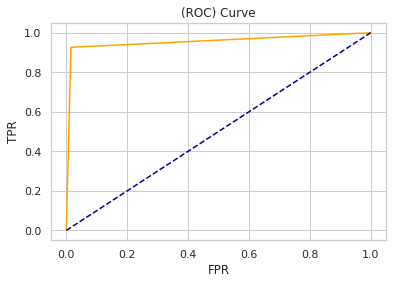

In [231]:
svc = SVC()

params = {
    'classifier__C': [1, 10, 100],
    'classifier__kernel' : ['poly']
}

result = testModel(method=svc, params=params, kernel='poly')
models_bo.append(result)

#### RBF SVM

{'classifier__C': 100, 'classifier__kernel': 'rbf'}
rbf not supported with Coef_ Funtion
Accuracy Score : 0.9739229024943311
Precision Score : 0.9320987654320988
Recall Score : 0.9263803680981595
F1 Score : 0.9292307692307692
AUC: 0.96
Confusion Matrix : 
[[708  11]
 [ 12 151]]


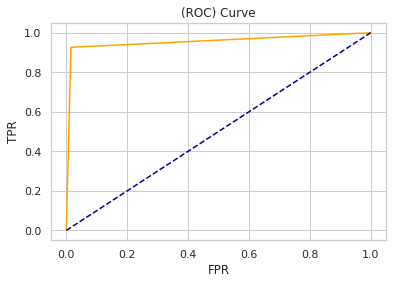

In [232]:
svc = SVC()

params = {
    'classifier__C': [1, 10, 100],
    'classifier__kernel' : ['rbf']
}

result = testModel(method=svc, params=params, kernel='rbf')
models_bo.append(result)

#### LINEAR SVM

{}


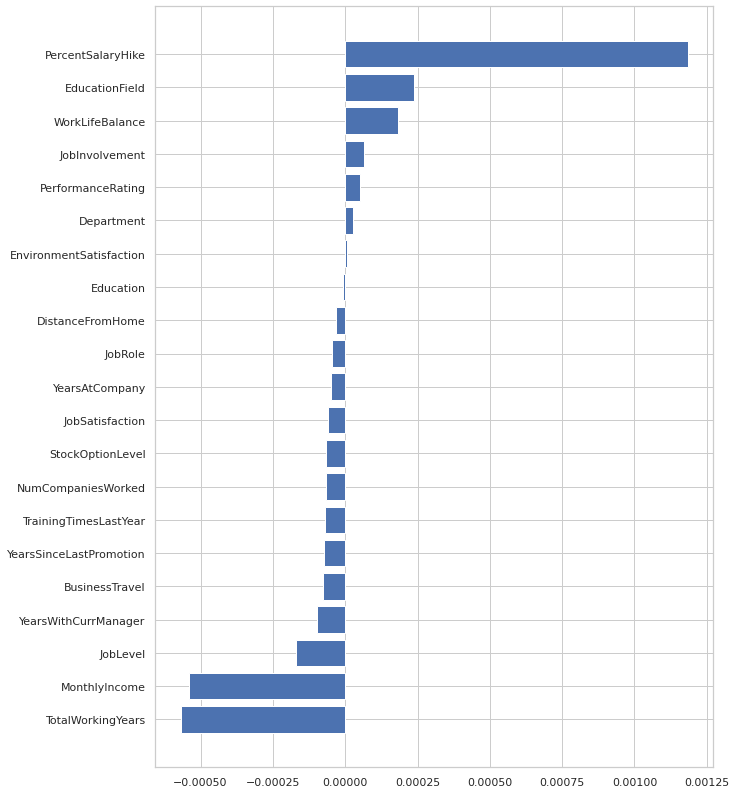

/home/xlabarbe/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xlabarbe/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score : 0.8151927437641724
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0
AUC: 0.50
Confusion Matrix : 
[[719   0]
 [163   0]]


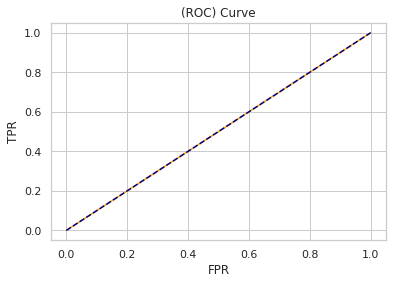

In [233]:
svc = SVC(kernel='linear')

params = {}

result = testModel(method=svc, params=params, kernel='linear')
models_bo.append(result)

## Conclusion

In [234]:
models_name = ['Logistic Regression', 'POLY SVM', 'RBF SVM', 'LINEAR SVM']
columns = ['Accuracy Score', 'Precision score', 'Recall Score', 'F1 Score']
final_models_bo = pd.DataFrame.from_records(models_bo, columns=columns)
final_models_bo.insert(0, 'Model Name', models_name)

final_models_bo

,Model Name,Accuracy Score,Precision score,Recall Score,F1 Score
0,Logistic Regression,0.824263,0.633333,0.116564,0.196891
1,POLY SVM,0.973923,0.932099,0.926380,0.929231
2,RBF SVM,0.973923,0.932099,0.926380,0.929231
3,LINEAR SVM,0.815193,0.000000,0.000000,0.000000


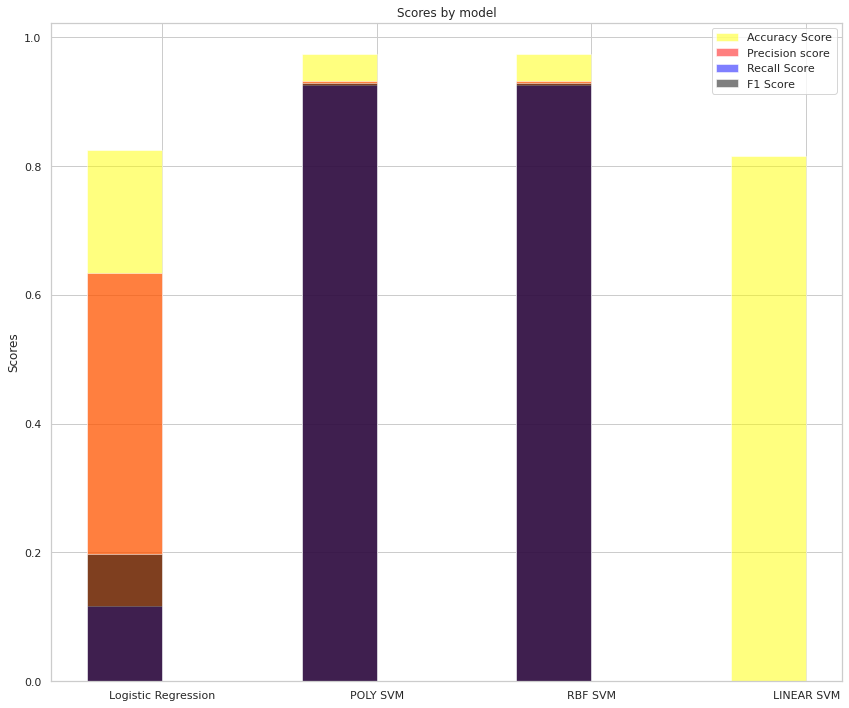

In [235]:
x = np.arange(len(models_name))  # the label location
width = 0.35  # the width of the bars
colors=['yellow', 'red', 'blue', 'black']

fig = plt.figure(figsize=(12, 10))
ax = fig.subplots()
for i, column in enumerate(columns):
  ax.bar(x - width/2, final_models_bo[column], width, label=column, color=colors[i], alpha = 0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model')
ax.set_xticks(x)
ax.set_xticklabels(models_name)
ax.legend()

fig.tight_layout()

Nous remarquons que nos premiers résultats ne sont pas convaincants, nous avons en effet obtenu un f1_score très faible sur la logistic regression. La matrice de condusion nous a notamment permis d'identifier un problème sur notre jeu de données : notre modèle s'entraine de manière inégale, il arrive facilement a prédire les attritions à 0 mais pas à 1. Cela viendrait peut-être d'une mauvaise répartition de nos données à la base...

Voici un graphique qui montre cette réparation inégale sur le jeu d'entrainement :

/home/xlabarbe/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


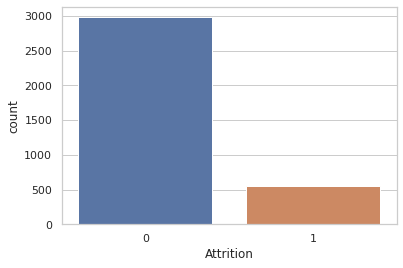

In [236]:
train = pd.DataFrame()
train["Attrition"] = Y_train
sns.set_theme(style="whitegrid")
ax=sns.countplot(train["Attrition"])
plt.show()

Ce graphique confirme notre hypothèse, il faut donc trouver un moyen de palier à cette problèmatique.

### Après l'*oversampling*
Après quelques recherches, nous avons trouvé une solution en utilisant l'oversampling. L'oversampling consiste à multiplier les exemples de la classe minoritaire de façon à lui donner plus de poids.

/home/xlabarbe/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


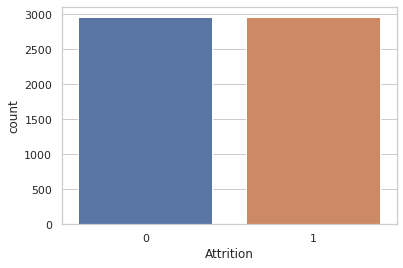

In [237]:
sm = SMOTE(random_state = 2) 
X_train_res, Y_train_res = sm.fit_resample(X_train_m, Y_train_m) 
train = pd.DataFrame()
train["Attrition"] = Y_train_res
sns.set_theme(style="whitegrid")
ax=sns.countplot(train["Attrition"])
plt.show()

In [238]:
models_ao = []

#### Régression Logistique

{'classifier__C': 100, 'classifier__solver': 'liblinear'}


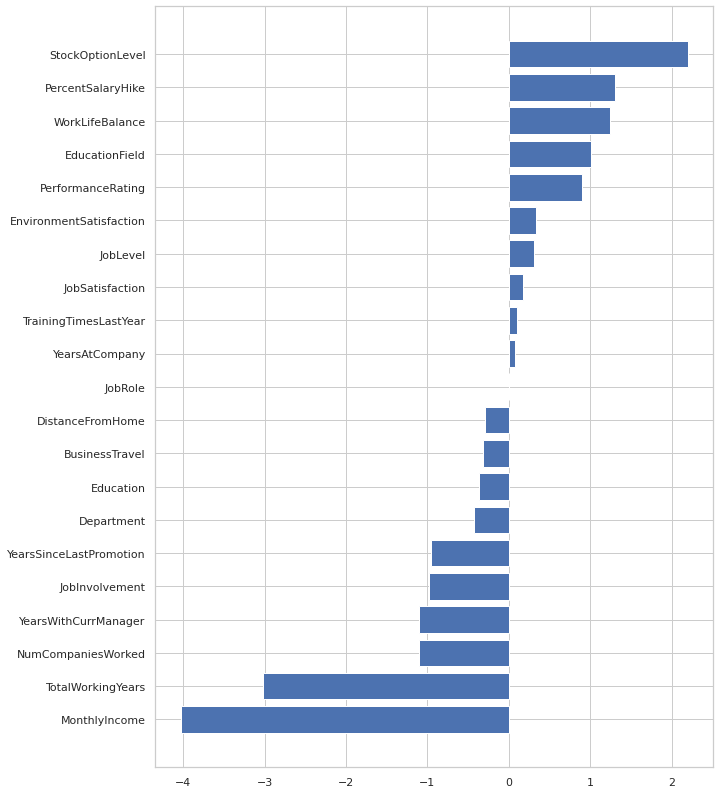

Accuracy Score : 0.7131519274376418
Precision Score : 0.3619631901840491
Recall Score : 0.7239263803680982
F1 Score : 0.4826175869120655
AUC: 0.72
Confusion Matrix : 
[[511 208]
 [ 45 118]]


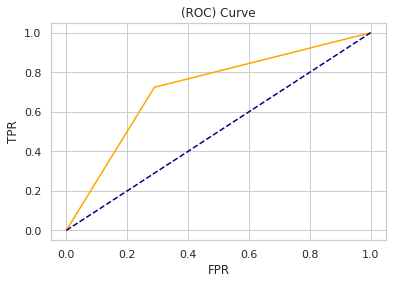

In [239]:
lr = LogisticRegression()

params = {
    'classifier__C': [10, 100],
    'classifier__solver' : ['liblinear']
}

result = testModel(method=lr, oversampled = True, params=params, kernel="linear")
models_ao.append(result)

#### POLY SVM

{'classifier__C': 100, 'classifier__kernel': 'poly'}
poly not supported with Coef_ Funtion
Accuracy Score : 0.9705215419501134
Precision Score : 0.9151515151515152
Recall Score : 0.9263803680981595
F1 Score : 0.9207317073170732
AUC: 0.95
Confusion Matrix : 
[[705  14]
 [ 12 151]]


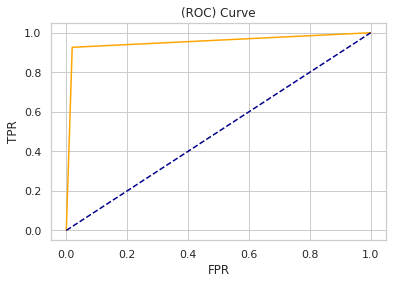

In [240]:
svc = SVC()

params = {
    'classifier__C': [1, 10, 100],
    'classifier__kernel' : ['poly']
}

result = testModel(method=svc, oversampled = True, params=params, kernel='poly')
models_ao.append(result)

#### RBF SVM

{'classifier__C': 100, 'classifier__kernel': 'rbf'}
rbf not supported with Coef_ Funtion
Accuracy Score : 0.9739229024943311
Precision Score : 0.9320987654320988
Recall Score : 0.9263803680981595
F1 Score : 0.9292307692307692
AUC: 0.96
Confusion Matrix : 
[[708  11]
 [ 12 151]]


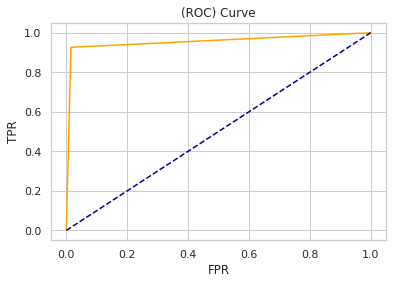

In [241]:
svc = SVC()

params = {
    'classifier__C': [1, 10, 100],
    'classifier__kernel' : ['rbf']
}

result = testModel(method=svc, oversampled = True, params=params, kernel='rbf')
models_ao.append(result)

#### LINEAR SVM

{}


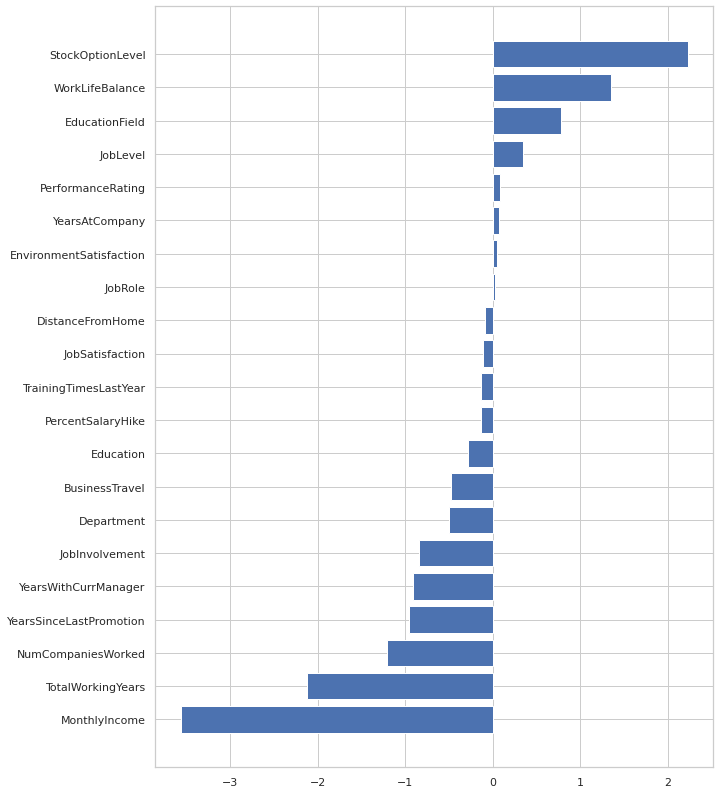

Accuracy Score : 0.7063492063492064
Precision Score : 0.3562874251497006
Recall Score : 0.7300613496932515
F1 Score : 0.4788732394366197
AUC: 0.72
Confusion Matrix : 
[[504 215]
 [ 44 119]]


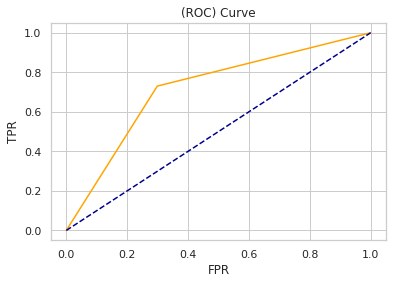

In [242]:
svc = SVC(kernel='linear')

params = {}

result = testModel(method=svc, oversampled = True, params=params, kernel='linear')
models_ao.append(result)

#### Conclusion

In [243]:
final_models_ao = pd.DataFrame.from_records(models_ao, columns=columns);
final_models_ao.insert(0, 'Model Name', models_name)
final_models_ao

,Model Name,Accuracy Score,Precision score,Recall Score,F1 Score
0,Logistic Regression,0.713152,0.361963,0.723926,0.482618
1,POLY SVM,0.970522,0.915152,0.926380,0.920732
2,RBF SVM,0.973923,0.932099,0.926380,0.929231
3,LINEAR SVM,0.706349,0.356287,0.730061,0.478873


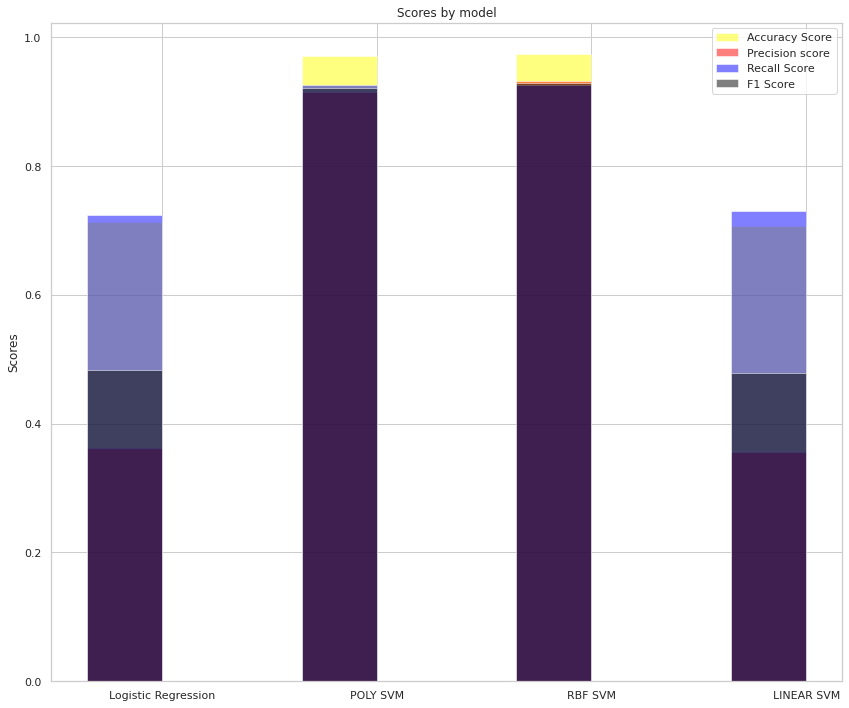

In [244]:
fig = plt.figure(figsize=(12, 10))
ax = fig.subplots()
for i, column in enumerate(columns):
  ax.bar(x - width/2, final_models_ao[column], width, label=column, color=colors[i], alpha = 0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model')
ax.set_xticks(x)
ax.set_xticklabels(models_name)
ax.legend()

fig.tight_layout()

## **Graphiques**

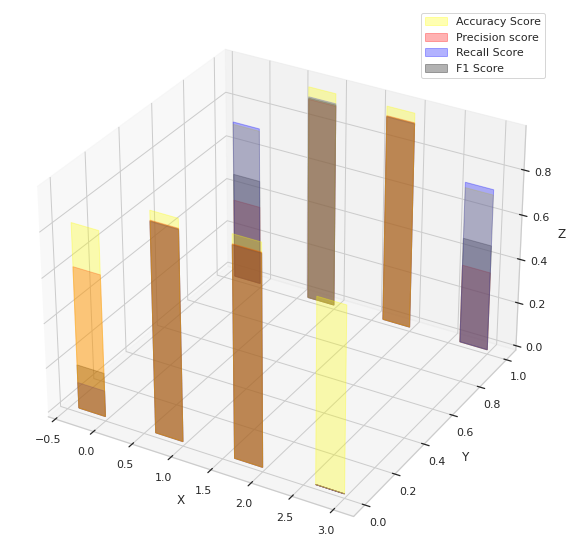

In [245]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
nbins = 10

for i, column in enumerate(columns):
  ax.bar(x - width/2, final_models_bo[column], width=width, zdir='y', zs=0, ec=colors[i], color=colors[i], alpha = 0.3)
for i, column in enumerate(columns):
  ax.bar(x - width/2, final_models_ao[column], width=width, label=column, zdir='y', zs=1, ec=colors[i], color=colors[i], alpha = 0.3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()

## **Evaluation & Interprétation**
Pour rappel des objectifs :
*Déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.*

Pour répondre à ces problématiques, nous allons répondre en deux parties.

Les facteurs les plus influents :
> Selon l'étude précédente qui consistait à sélectionner les facteurs les plus influents, nous avons vu pu en créer un profil type qui aura plus tendance à quitter l'entreprise :
* Directeur de recherche ;
* Il vient d'avoir un nouveau manager ;
* Il a déjà travaillé dans 6 entreprises ;
* Il est nouveau dans l'entreprise ;
* Il a fait des études en ressources humaines ;
* Avec un mauvais environnement de travail ;
* Il voyage fréquemment.

Pistes d'améliorations :
> Nous avons pu voir les facteurs les plus influents, nous pouvons désormais tirer certains axes d'améliorations dans le but de **donner envie de rester** aux collaborateurs :
* Améliorer la première année lors d'un changement de manager ;
* Sonder les personnes qui ont répondu qu'ils travaillaient dans un mauvais environnement de travail pour identifier les problèmes qu'ils rencontrent ;
* Elargir le panel des missions ou/et augmenter le salaire des directeurs de recherches ;
* Améliorer l'accueil des nouveaux arrivants ;
* Être plus reconnaissant avec les personnes qui voyagent fréquemment en aménageant leurs horaires de travail par exemple ;
* Améliorer les conditions de travail des collaborateurs en ressources humaines (certainement dû au turn-over, surcharge de travail ?).

Nous avons également pu entrainer une IA très performante (97% de réussite sur la prédiction) qui permet de prédrire si un employé a des chances de quitter l'entreprise ou non. Toujours dans l'objectif de donner l'envie de rester à cet employé, si jamais le modèle indique en sortie qu'il a des risques de quitter l'entreprise, il faudra mettre en place des actions comme citées précédemment pour améliorer ses conditions de vie au travail.

## **Ethique**
Dans le cadre de la mise en place de l’IA nous devons traiter un certain nombre de données, c’est pourquoi la question de l’éthique rentre en compte. Notre projet rentrit dans le cadre d'une enquête cherchant à répondre à des besoins internes à l'entreprise. Il n'est donc obligatoire que le responsable de traitement ait obtenu des personnes concernées un consentement exprès à l'analyse de leurs données personnelles. Or il n'est nulle part stipulé que les employés concernés par cette étude ont donné leur accord.
Nous avons donc décidé en tant que spécialistes d'analyses des données de ne pas prendre en compte certains champs qui atteignent la vie privée car il se pourrait que l'entreprise ait collecté ces informations sur les employés contre leur gré.


Lors du nettoyage des données nous avons donc décidé d’enlever certains champs de données qui ne semblaient pas éthiques et donc non utilisés pour la mise en place de l’IA. Ces champs sont :
  * Gender ;
  * Age ;
  * Over18 ;
  * MaritalStatus.

Pour nous, ces données sont des facteurs discriminants, intrusifs dans la vie privée et donc non éthique. Sortir une analyse en fonction d'une donnée privée telle que l'âge de la personne ou de son statut marital est quelque chose de non accepté pour notre équipe et c’est pour cela que ses données ne seront pas traitées.

De plus les fichiers "out_time" et "in_time" comportent des données concernant les heures d'arrivée et de départ des employés au cours d'une année. Ce type d'information peut être jugé intrusif. Comme dit précedemment notre équipe ne souhaite pas intervenir sur des données concernant la vie privée.


Dans le jeu de données, l'entreprise a remplacé le nom et prénom par un ID. C’est un point très important car ce type d’information doit rester confidentiel.